# 注意力机制
## 注意力提示
- “注意力”：指的是模型分配给它所处理信息中不同部分的权重或重要性分数。
- “提示”：指的是引导模型如何分配这些权重的线索或指令。
- 过程解释：编码器读取输入序列，每个输入词都生成一个隐藏状态，解码器初始化开始生成第一个目标词的时候，它自己的隐藏状态（比如$s_0$）来自编码器的最后一个状态（因为最后一个状态通常包含整个输入序列的信息）或者使用一个特殊的开始标记（提醒解码器开始解码）（一般是解码器自己有一个初始向量或者这个开始标记带着一个学习向量），然后就根据这个初始的向量和编码器的输出向量通过注意力机制计算（用初始向量去乘以每一个编码器的隐藏状态，得到他们各自对应的分数（这个结果就是概率，即相关性），然后将这个分数使用$\mathrm{Softmax}$函数标准化成总和为$1$的概率分布（权重），然后这个权重就是最终的**注意力提示**（模型会注意权重高的）），然后就是上下文向量的更新，各个权重乘以编码器对应位置的各个隐藏状态相加就是更新后的上下文向量（主要是权重最大的对应的隐状态的信息），然后解码器生成第一个词（将初始向量和上下文向量拼接在一起，通过一个前馈神经网络和一个$\mathrm{softmax}$层，然后得到一个覆盖整个目标词汇表的概率分布，概率最高的就是模型预测的第一个词），在之后就是重复上述步骤，直到生成整个序列。
- 注意力机制框架：

![注意力机制框架图](../image/注意力机制框架图.jpg)



## 注意力汇聚：$\mathrm{Nadaraya-Watson}$核回归
### 数据集生成
- 使用非线性函数：$y_i=2\sin(x_i)+x_i^{0.8}+\epsilon$，其中$\epsilon$服从均值为$0$和标准差为$0.5$的正态分布

### 平均汇聚
$$f(x)=\frac{1}{n}\sum^n_{i=1}y_i$$

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

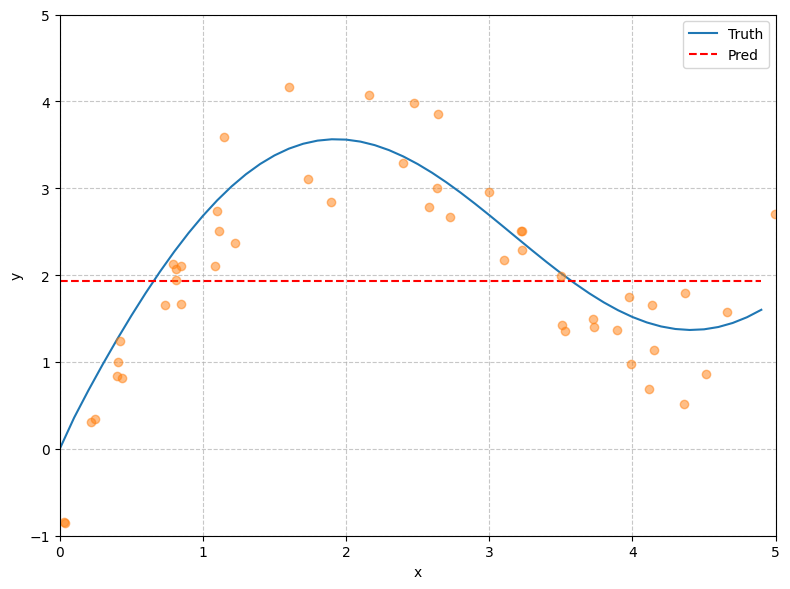

In [2]:
import torch
import matplotlib.pyplot as plt

# 生成数据
n_train = 50
x_train, _ = torch.sort(torch.rand(n_train) * 5)

def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))
x_test = torch.arange(0, 5, 0.1)
y_truth = f(x_test)
n_test = len(x_test)

def plot_kernel_reg(y_hat):
    fig, ax = plt.subplots(figsize=(8, 6))
    # 设置白色背景
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    ax.plot(x_test, y_truth, label='Truth')
    # 红色虚线
    ax.plot(x_test, y_hat, 'r--', label='Pred')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xlim([0.0, 5.0])
    ax.set_ylim([-1, 5])
    ax.legend()
    ax.plot(x_train, y_train, 'o', alpha=0.5)
    ax.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

### 非参数注意力汇聚
- $\mathrm{Nadaraya-Watson}$核回归:
$$f(x)=\sum^n_{i=1}\frac{K(x-x_i)}{\sum_{j=1}^nK(x-x_j)}y_i$$
- 其中$K$是核（函数），由此得出通用的注意力汇聚公式：
$$f(x)=\sum^n_{i=1}\alpha(x,x_i)y_i$$
- 其中$x$是查询，$(x_i,y_i)$是键值对，注意力权重$\alpha(x,x_i)$是查询$x$和键$x_i$之间的关系建模（键越接近查询，那么分配给这个键对应的$y_i$的注意力权重会越大（考虑到一些具体的核函数上））
- **注**：对于任何查询，模型在所有键值对注意力权重都是一个有效的概率分布：它们是非负的，并且总和为1。

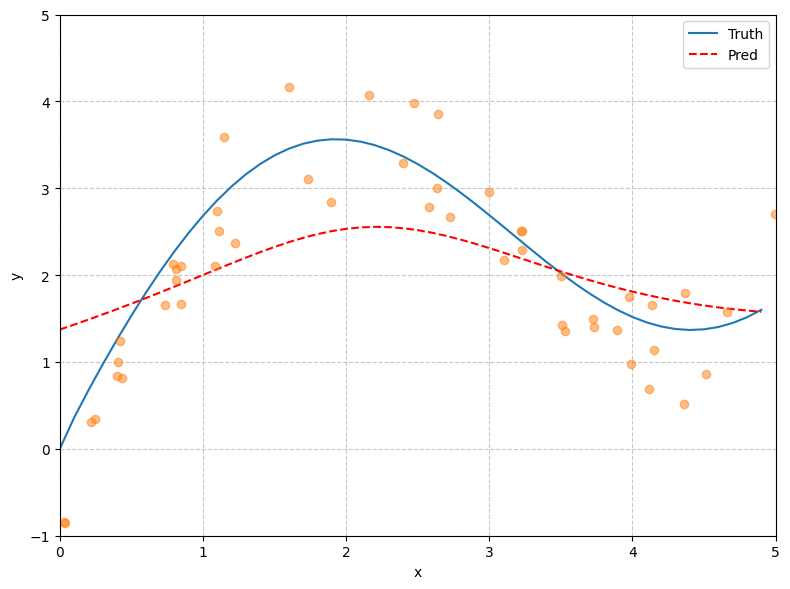

In [3]:
import torch.nn as nn
# X_repeat的形状:(n_test,n_train),
# 每一行都包含着相同的测试输入（例如：同样的查询）
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# x_train包含着键。attention_weights的形状：(n_test,n_train),
# 每一行都包含着要在给定的每个查询的值（y_train）之间分配的注意力权重
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
# y_hat的每个元素都是值的加权平均值，其中的权重是注意力权重
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

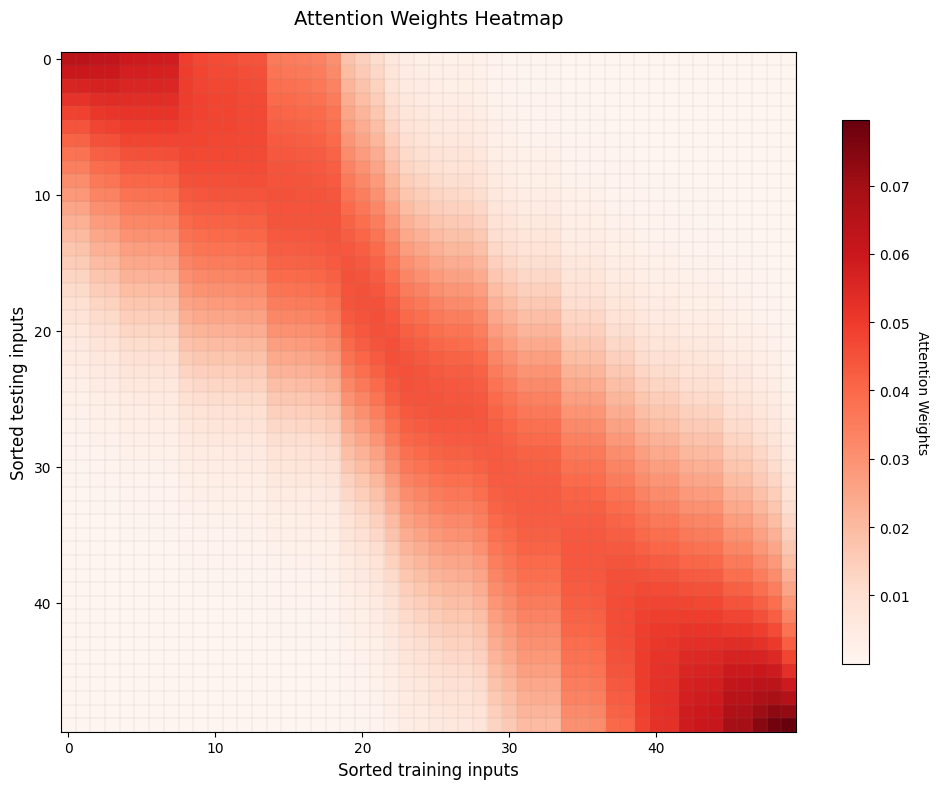

In [6]:
import numpy as np

def show_heatmaps(attention_weights, xlabel='Sorted training inputs', ylabel='Sorted testing inputs',
                 title='Attention Weights Heatmap', figsize=(10, 8), cmap='Reds'):
    """
    显示注意力权重的热力图
    
    参数:
    attention_weights: 注意力权重矩阵 (测试样本数, 训练样本数)
    xlabel: x轴标签
    ylabel: y轴标签
    title: 图标题
    figsize: 图形大小
    cmap: 颜色映射
    """
    # 转换张量为numpy数组
    if hasattr(attention_weights, 'detach'):
        data = attention_weights.detach().numpy()
    elif hasattr(attention_weights, 'numpy'):
        data = attention_weights.numpy()
    else:
        data = np.array(attention_weights)
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # 绘制热力图
    im = ax.imshow(data, cmap=cmap, aspect='auto', interpolation='nearest')
    
    # 设置坐标轴标签
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    
    # 添加颜色条
    cbar = fig.colorbar(im, ax=ax, shrink=0.8)
    cbar.ax.set_ylabel('Attention Weights', rotation=-90, va="bottom", fontsize=10)
    
    # 设置标题
    ax.set_title(title, fontsize=14, pad=20)
    
    # 可选：添加网格
    ax.set_xticks(np.arange(-0.5, data.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-0.5, data.shape[0], 1), minor=True)
    ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.1)
    ax.tick_params(which="minor", size=0)
    
    plt.tight_layout()
    plt.show()

show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0)[0, 0])

In [7]:
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

In [8]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

tensor([[[ 4.5000]],

        [[14.5000]]])

- $\mathrm{Nadaraya‐Watson}$核回归的带参数版模型

In [9]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand(1, requires_grad=True))
    
    def forward(self, queries, keys, values):
        # 一步计算注意力权重，利用广播机制
        diff = queries.unsqueeze(1) - keys.unsqueeze(0)  # (n_queries, n_keys, feature_dim)
        squared_dist = -((diff * self.w) ** 2) / 2
        self.attention_weights = nn.functional.softmax(squared_dist, dim=1)
        
        # 使用einsum进行加权求和
        return torch.einsum('bik,bk->bi', self.attention_weights, values).squeeze()

In [10]:
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# keys的形状:('n_train'，'n_train'-1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

D:\Anaconda3\envs\DL\Lib\site-packages\torch\nn\modules\loss.py:616: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 50])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\DaiYongle\AppData\Local\Temp\ipykernel_28168\1908680129.py:15: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:836.)
  current_loss = float(l.sum())


epoch 1, loss 2998.712891
epoch 2, loss 420.677490
epoch 3, loss 420.677490
epoch 4, loss 420.677490
epoch 5, loss 420.677490


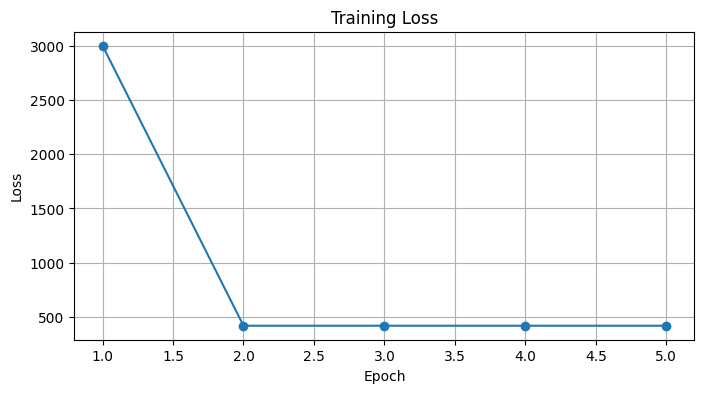

In [11]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)

# 记录训练过程
epochs = 5
losses = []

for epoch in range(epochs):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    
    current_loss = float(l.sum())
    losses.append(current_loss)
    print(f'epoch {epoch + 1}, loss {current_loss:.6f}')

# 绘制损失曲线
plt.figure(figsize=(8, 4))
plt.plot(range(1, epochs + 1), losses, 'o-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()

Raw network output: torch.Size([50, 50])
After taking diagonal: torch.Size([50])


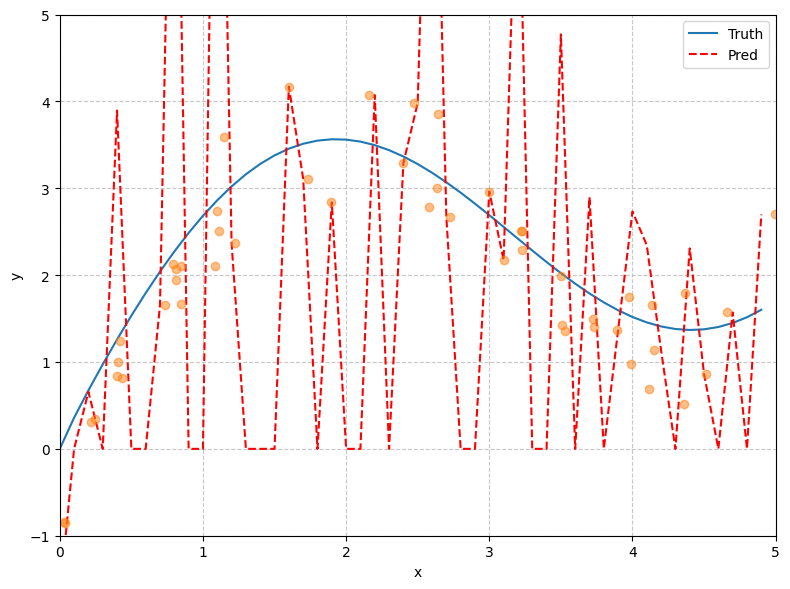

In [12]:
keys = x_train.repeat((n_test, 1))
values = y_train.repeat((n_test, 1))

with torch.no_grad():
    y_hat = net(x_test, keys, values)
    print(f"Raw network output: {y_hat.shape}")  # (50, 50)
    
    # 取对角线元素 - 这通常表示每个查询对应的预测
    y_hat = torch.diag(y_hat)
    print(f"After taking diagonal: {y_hat.shape}")  # (50,)

plot_kernel_reg(y_hat)

## 注意力评分函数
- 其实就是用来计算两个向量之间的相关性（相似度）的

![计算注意力汇聚](../image/注意力汇聚流程.png)

### 掩蔽$\mathrm{softmax}$操作
- 就是用来仅将有意义的词元作为值来获取注意力汇聚的，指定一个有效序列长度（就是词元的个数），然后就可以在$\mathrm{softmax}$的时候过滤掉超出指定长度的位置

In [13]:

import torch
from torch import nn

def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项"""
    maxlen = X.size(1)
    mask = torch.arange(maxlen, dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

def masked_softmax(X, valid_lens):
    """通过在最后一个轴上掩蔽元素来执行softmax操作"""
    # X: 3D张量，valid_lens: 1D或2D张量
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
        X = sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                          value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [14]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.6066, 0.3934, 0.0000, 0.0000],
         [0.4356, 0.5644, 0.0000, 0.0000]],

        [[0.3136, 0.3124, 0.3740, 0.0000],
         [0.2742, 0.3410, 0.3848, 0.0000]]])

In [15]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.3785, 0.3345, 0.2870, 0.0000]],

        [[0.5575, 0.4425, 0.0000, 0.0000],
         [0.2313, 0.2969, 0.1845, 0.2873]]])

### 加性注意力（通常针对查询和键是不同长度的矢量）
- 使用单隐藏层的前馈神经网络来计算分数的：
$$score(q, k)=v^T\tanh (W_qq+W_kk)$$
- 就是将$q$（查询）和$k$（键）分别通过线性变换（矩阵乘法$W$）后相加，经过$\tanh$激活函数，最后通过向量$v^T$投影成一个标量。

In [16]:
class AdditiveAttention(nn.Module):
    """加性注意力"""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # 在维度扩展后，
        # queries的形状：(batch_size，查询的个数，1，num_hidden)
        # key的形状：(batch_size，1，"键－值"对的个数，num_hiddens)
        # 使用广播方式进行求和
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # self.w_v仅有一个输出，因此从形状中移除最后那个维度。
        # scores的形状：(batch_size，查询的个数，"键-值"对的个数)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # values的形状：(batch_size，"键－值"对的个数，值的维度)
        return torch.bmm(self.dropout(self.attention_weights), values)

# 测试代码
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
# values的小批量，两个值矩阵是相同的
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(2, 1, 1)
valid_lens = torch.tensor([2, 6])
attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8, dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

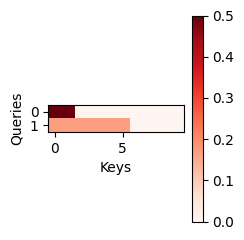

In [17]:
import numpy as np

def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5), cmap='Reds'):
    """显示矩阵热图"""
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize,
                             sharex=True, sharey=True, squeeze=False)
    
    for i in range(num_rows):
        for j in range(num_cols):
            ax = axes[i, j]
            # 将PyTorch张量转换为numpy数组
            if torch.is_tensor(matrices):
                matrix = matrices[i, j].detach().numpy()
            else:
                matrix = matrices[i, j]
            im = ax.imshow(matrix, cmap=cmap)
            
            if titles:
                ax.set_title(titles[i][j])
            
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
            
            # 添加颜色条
            fig.colorbar(im, ax=ax)
    
    plt.tight_layout()
    plt.show()

show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
              xlabel='Keys', ylabel='Queries')

### 缩放点积注意力
- 为了解决在算注意力分数的时候，由于向量的维度过高，导致点积结果很大，然后在$\mathrm{Softmax}$的时候梯度变得很小（梯度消失）这个问题，让原本的结果除以一个**缩放因子**（键向量维度的平方根），这样就将这个分数缩放到了一个比较温和的数值范围。
$$\mathrm{softmax}\Big(\frac{\mathbf{QK}^T}{\sqrt{d}}\Big)\mathbf{V}\in\mathbb{R}^{n\times v}$$

In [18]:
import math

class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
    # queries的形状：(batch_size，查询的个数，d)
    # keys的形状：(batch_size，“键－值”对的个数，d)
    # values的形状：(batch_size，“键－值”对的个数，值的维度)
    # valid_lens的形状:(batch_size，)或者(batch_size，查询的个数)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # 设置transpose_b=True为了交换keys的最后两个维度
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [19]:
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

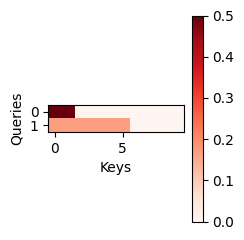

In [20]:
show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
              xlabel='Keys', ylabel='Queries')